In [1]:
from pytorch_model import load_wpod
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms, utils, models
from torch import nn
import torch
from src.label import Label, Shape
from src.utils import getWH, nms, im2single, IOU_centre_and_dims
from src.projection_utils import getRectPts, find_T_matrix
import time
from utils import *
from tqdm import tqdm
from torchviz import make_dot

In [2]:
import sys
import cv2
import numpy as np
import traceback

import darknet.python.darknet as dn

from os.path 				import splitext, basename
from glob					import glob
from darknet.python.darknet import detect
from src.label				import dknet_label_conversion
from src.utils 				import nms

In [3]:
pil_to_tensor = transforms.ToTensor()
tensor_to_pil = transforms.ToPILImage()

In [4]:
class DLabel (Label):

    def __init__(self,cl,pts,prob):
        self.pts = pts
        tl = np.amin(pts,1)
        br = np.amax(pts,1)
        Label.__init__(self,cl,tl,br,prob)


def reconstruct(Iorig,I,Y,out_size,threshold=.9):

    net_stride 	= 2**4
    side = ((208. + 40.)/2.)/net_stride # 7.75
    
    Probs = Y[...,0]
    Affines = Y[...,2:]
    rx,ry = Y.shape[:2]
    ywh = Y.shape[1::-1]
    iwh = np.array(I.shape[1::-1],dtype=float).reshape((2,1))
    xx,yy = np.where(Probs>threshold)
    
    WH = getWH(I.shape)
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha

    base = lambda vx,vy: np.matrix([[-vx,-vy,1.],[vx,-vy,1.],[vx,vy,1.],[-vx,vy,1.]]).T
    labels = []

    for i in range(len(xx)):
        y,x = xx[i],yy[i]
        affine = Affines[y,x]
        prob = Probs[y,x]
        mn = np.array([float(x) + .5,float(y) + .5])
        A = np.reshape(affine,(2,3))
        A[0,0] = max(A[0,0],0.)
        A[1,1] = max(A[1,1],0.)
        pts = np.array(A*base(vxx,vyy)) #*alpha
        pts_MN_center_mn = pts*side
        pts_MN = pts_MN_center_mn + mn.reshape((2,1))

        pts_prop = pts_MN/MN.reshape((2,1))

        labels.append(DLabel(0,pts_prop,prob))

    final_labels = nms(labels,.1)
    TLps = []

    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for i,label in enumerate(final_labels):

            t_ptsh 	= getRectPts(0,0,out_size[0],out_size[1])
            ptsh 	= np.concatenate((label.pts*getWH(Iorig.shape).reshape((2,1)),np.ones((1,4))))
            H 		= find_T_matrix(ptsh,t_ptsh)
            Ilp 	= cv2.warpPerspective(Iorig,H,out_size,borderValue=.0)

            TLps.append(Ilp)

    return final_labels,TLps
    

def detect_lp(model,I,max_dim,net_step,out_size,threshold,masked_pattern=None,train=None):

    min_dim_img = min(I.shape[:2])
    factor 		= float(max_dim)/min_dim_img

    w,h = (np.array(I.shape[1::-1],dtype=float)*factor).astype(int).tolist()
    w += (w%net_step!=0)*(net_step - w%net_step)
    h += (h%net_step!=0)*(net_step - h%net_step)
    Iresized = cv2.resize(I,(w,h))
    print(Iresized.shape)
    Tn = Iresized.copy()
    Tn = Tn.reshape((1,Tn.shape[0],Tn.shape[1],Tn.shape[2]))
    Tn = torch.tensor(Tn, device=device).permute(0,3,1,2)
    #display(tensor_to_pil(Tn.cpu()[0]))
    start = time.time()
    model.eval()
    if masked_pattern is not None:
        Tn = masked_pattern*Tn
    if train:
        Yr = model(Tn).permute(0,2,3,1)
        return None,None,None,Yr,Tn
    else:
        display(tensor_to_pil(Tn.cpu()[0]))
        Yr = model(Tn).permute(0,2,3,1)
        Y2 = np.squeeze(Yr)
        Y2 = Y2.cpu().detach().numpy()
    elapsed = time.time() - start
    
    L,TLps = reconstruct(I,Iresized,Y2,out_size,threshold)

    return L,TLps,elapsed,Yr.cpu(),Tn
    
def getResizedImage(I,net_step):
    ratio = float(max(tvehicle.shape[:2]))/min(tvehicle.shape[:2])
    side  = int(ratio*288.)
    max_dim = min(side + (side%(2**4)),608)
    
    min_dim_img = min(I.shape[:2])
    factor 		= float(max_dim)/min_dim_img

    w,h = (np.array(I.shape[1::-1],dtype=float)*factor).astype(int).tolist()
    w += (w%net_step!=0)*(net_step - w%net_step)
    h += (h%net_step!=0)*(net_step - h%net_step)
    Iresized = cv2.resize(I,(w,h))
    return Iresized

def augment_sample(I,pts,dim):

	maxsum,maxangle = 120,np.array([80.,80.,45.])
	angles = np.random.rand(3)*maxangle
	if angles.sum() > maxsum:
		angles = (angles/angles.sum())*(maxangle/maxangle.sum())

	I = im2single(I)
	iwh = getWH(I.shape)

	whratio = random.uniform(2.,4.)
	wsiz = random.uniform(dim*.2,dim*1.)
	
	hsiz = wsiz/whratio

	dx = random.uniform(0.,dim - wsiz)
	dy = random.uniform(0.,dim - hsiz)

	pph = getRectPts(dx,dy,dx+wsiz,dy+hsiz)
	pts = pts*iwh.reshape((2,1))
	T = find_T_matrix(pts2ptsh(pts),pph)

	H = perspective_transform((dim,dim),angles=angles)
	H = np.matmul(H,T)

	Iroi,pts = project(I,H,pts,dim)
	
	hsv_mod = np.random.rand(3).astype('float32')
	hsv_mod = (hsv_mod - .5)*.3
	hsv_mod[0] *= 360
	Iroi = hsv_transform(Iroi,hsv_mod)
	Iroi = np.clip(Iroi,0.,1.)

	pts = np.array(pts)

	if random.random() > .5:
		Iroi,pts = flip_image_and_pts(Iroi,pts)

	tl,br = pts.min(1),pts.max(1)
	llp = Label(0,tl,br)

	return Iroi,llp,pts

def l1(true,pred,szs):
	b,h,w,ch = szs
	res = torch.reshape(true-pred,(b,h*w*ch))
	res = torch.abs(res)
	res = torch.sum(res,1)
	return res

def logloss(Ptrue,Pred,szs,eps=10e-10):
	b,h,w,ch = szs
	Pred = torch.clamp(Pred,eps,1.)
	Pred = -torch.log(Pred)
	Pred = Pred*Ptrue
	Pred = torch.reshape(Pred,(b,h*w*ch))
	Pred = torch.sum(Pred,1)
	return Pred

def total_loss(Ytrue, Ypred, alpha=1):

    b = Ytrue.size()[0]
    h = Ytrue.size()[1]
    w = Ytrue.size()[2]

    obj_probs_true = Ytrue[...,0]
    obj_probs_pred = Ypred[...,0]

    #print((obj_probs_true>0).nonzero())
    #print((obj_probs_pred>0.5).nonzero())
    #print(obj_probs_true[obj_probs_true>0],obj_probs_pred[obj_probs_true>0])
    #print(obj_probs_true[obj_probs_pred>0.5],obj_probs_pred[obj_probs_pred>0.5])
    
    non_obj_probs_true = 1. - Ytrue[...,0]
    non_obj_probs_pred = Ypred[...,1]

    affine_pred	= Ypred[...,2:]
    pts_true 	= Ytrue[...,1:]

    affine_pred[...,0][affine_pred[...,0]<0] = 0
    affine_pred[...,4][affine_pred[...,4]<0] = 0
    affinex = torch.stack([affine_pred[...,0],affine_pred[...,1],affine_pred[...,2]],3)
    affiney = torch.stack([affine_pred[...,3],affine_pred[...,4],affine_pred[...,5]],3)
    v = 0.5
    base = torch.tensor([[[[-v,-v,1., v,-v,1., v,v,1., -v,v,1.]]]],device=device)
    base = base.repeat(b,h,w,1)
    pts = torch.zeros((b,h,w,0),device=device)

    for i in range(0,12,3):
        row = base[...,i:(i+3)]
        ptsx = torch.sum(affinex*row,3)
        ptsy = torch.sum(affiney*row,3)

        pts_xy = torch.stack([ptsx,ptsy],3)
        pts = (torch.cat([pts,pts_xy],3))

    flags = torch.reshape(obj_probs_true,(b,h,w,1))
    res   = 1.*l1(pts_true*flags,pts*flags,(b,h,w,4*2))
    #res  += 1.*alpha*logloss(obj_probs_true,obj_probs_pred,(b,h,w,1))
    #res  += 1.*logloss(non_obj_probs_true,non_obj_probs_pred,(b,h,w,1))
    return res

In [5]:
def labels2output_map(label,lppts,dim,stride):

    #side = ((float(dim) + 40.)/2.)/stride # 7.75 when dim = 208 and stride = 16
    
    side = 7.75
    
    outsize1, outsize2 = int(dim[0]/stride), int(dim[1]/stride)
    Y  = np.zeros((outsize1,outsize2,2*4+1),dtype='float32')
    MN = np.array([outsize1,outsize2])
    WH = np.array([dim[0],dim[1]],dtype=float)

    tlx,tly = np.floor(np.maximum(label.tl(),0.)*MN).astype(int).tolist()
    brx,bry = np.ceil (np.minimum(label.br(),1.)*MN).astype(int).tolist()

    for x in range(tlx,brx):
        for y in range(tly,bry):

            mn = np.array([float(x) + .5, float(y) + .5])
            iou = IOU_centre_and_dims(mn/MN,label.wh(),label.cc(),label.wh())

            if iou > .5:

                p_WH = lppts*WH.reshape((2,1))
                p_MN = p_WH/stride

                p_MN_center_mn = p_MN - mn.reshape((2,1))

                p_side = p_MN_center_mn/side

                Y[x,y,0] = 1.
                Y[x,y,1:] = p_side.T.flatten()

    return Y

Searching for license plates using WPOD-NET
(2268, 4032, 3)
		Bound dim: 512, ratio: 1.777778
(512, 912, 3)


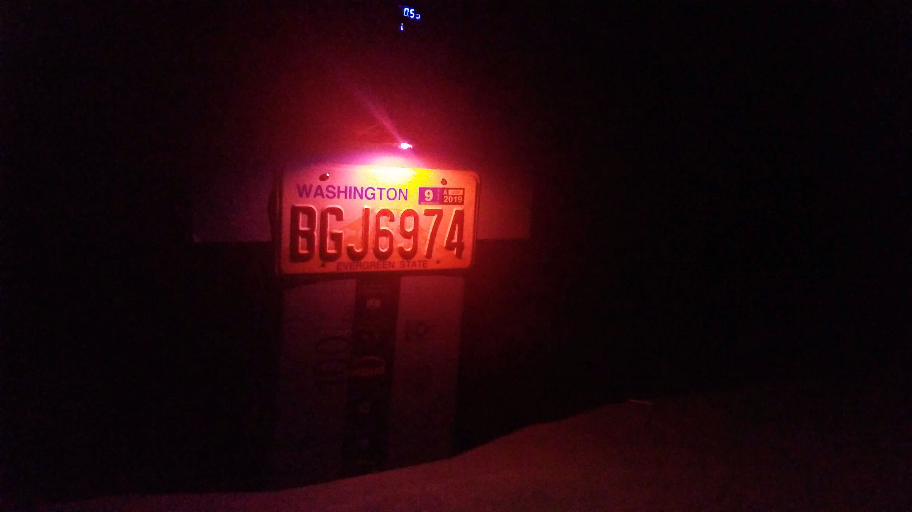

found
torch.Size([1, 32, 57, 8])


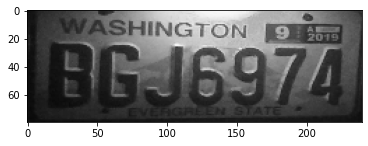

In [6]:
def adjust_pts(pts,lroi):
	return pts*lroi.wh().reshape((2,1)) + lroi.tl().reshape((2,1))


output_dir = "./temp"

lp_threshold = .5

wpod_net = load_wpod()
wpod_net.to(device)
wpod_net.eval()
print('Searching for license plates using WPOD-NET')

tvehicle = cv2.imread('Plate_examples/lp_white_new.jpg')
#tvehicle = cv2.resize(tvehicle,(208,208))
#Ivehicle = Ivehicle[450:630, 480:1170]
plt.imshow(tvehicle)
print(tvehicle.shape)
#Ivehicle = cv2.bitwise_and(Ivehicle, Ivehicle, mask=cv2.bitwise_not(get_mask(Ivehicle)))
ratio = float(max(tvehicle.shape[:2]))/min(tvehicle.shape[:2])
side  = int(ratio*288.)
bound_dim = min(side + (side%(2**4)),608)
print("\t\tBound dim: %d, ratio: %f" % (bound_dim,ratio)) 

Llp,LlpImgs,_,Y3,_ = detect_lp(wpod_net,im2single(tvehicle),bound_dim,2**4,(240,80),lp_threshold)

if len(LlpImgs):
    print('found')
    Ilp = LlpImgs[0]
    Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
    Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)

    s = Shape(Llp[0].pts)
    cv2.imwrite('./temp/lp.jpg',255*Ilp)
    plt.imshow(Ilp)
print(Y3.shape)

In [7]:
tl,br = s.pts.min(1),s.pts.max(1)
llp = Label(0,tl,br)
print(tl,br)
Y = labels2output_map(llp,s.pts,(512,912),16)
Y = torch.tensor(Y)
Y = Y.unsqueeze(0)

[0.30365879 0.34297984] [0.52244512 0.53857862]


In [8]:
Y3 = Y3.to(device)
Y = Y.to(device)
print(Y.size(), Y3.size())
total_loss(Y,Y3)

torch.Size([1, 32, 57, 9]) torch.Size([1, 32, 57, 8])


tensor([53.4758], device='cuda:0', grad_fn=<MulBackward0>)

(288, 288)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

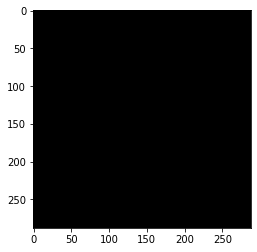

In [10]:
def get_mask(Ivehicle,h=None,w=None,d=None):
    if h:
        height,width,depth = h,w,d
    else: height,width,depth = Ivehicle.shape
    x = Ivehicle.copy()
    x = cv2.resize(x,(height,width))
    circle_img = np.zeros((height,width), np.uint8)
    #cv2.rectangle(circle_img,(86,107),(212,152),280,thickness=-1)
    #cv2.rectangle(circle_img,(86,107),(212,152),280,thickness=-1)
    print(circle_img.shape)
    #circle_img = circle_img.reshape((1,circle_img.shape[0],circle_img.shape[1]))
    #circle_img = torch.tensor(circle_img).permute(0,1,2)
    #cv2.rectangle(circle_img,(480,480),(1170,570),255,thickness=-1)
    plt.imshow(cv2.bitwise_and(x, x, mask=circle_img))
    return circle_img
get_mask(tvehicle,288,288,3)

In [11]:
account_resize = True
repeat_size=1

#For resize post convolution
if account_resize:
    repeat_size = int(3024/3024)
    img = Ivehicle.resize((208,208))
    model_img_size = img.size[0]
    img_t = pil_to_tensor(img)
    img_t = img_t.to(device)
    def resize2d(img, size):
        return (F.adaptive_avg_pool2d(Variable(img), size)).data
    def upsample2d(img, size=224):
        upsample = nn.Upsample(size=size, mode='bilinear', align_corners=False)
        return upsample(torch.unsqueeze(img, 0))[0]
else:
    model_img_size = 224

In [12]:
model_img_size = 512

In [13]:
# typical exposure is in form 1/n s. Available: 15, 20, 25 30, 40, 50, 60, 80, 100, 125, 160, 200, 250
exposure = 1000
exp_micros = 1000000/exposure          # get exposure in microseconds
img_ratio = 2268 / model_img_size      # every row in model is img_ratio rows in original image
model_tr = 10 * img_ratio              # multiply real tr (10 micros) by img_ratio to find model tr
conv_size = exp_micros / model_tr      # divide exposure time by tr to find convolution size
conv_size = int(conv_size)             # Need closest integer approximation. Won't cause a significant difference
conv_size

22

In [45]:
#Ivehicle = cv2.imread('Plate_examples/lptest.jpg')
r = cv2.imread('Plate_examples/lp_red.jpg')
g = cv2.imread('Plate_examples/lp_green.jpg')
b = cv2.imread('Plate_examples/lp_blue.jpg')
white = cv2.imread('Plate_examples/lp_white_new.jpg')
canvas = np.zeros([2268,4032,3],dtype=np.uint8)
canvas[:,:,0] = b[:,:,0]
canvas[:,:,1] = g[:,:,1]
canvas[:,:,2] = r[:,:,2]

# currently using the combined image
Ivehicle = white

In [15]:
sz = model_img_size + conv_size - 1 # 300   #Length of input signal
c = 0    #Ambient light ratio
c_limits = [0,0]
batch = 8
channels = 3
# change of variable term to optimise on
w = torch.rand([channels,sz,1], requires_grad=True, dtype=torch.float, device=device)

#Create the mask to only illuminate the object
#mask = torch.tensor(get_mask(Ivehicle,288,288,3), dtype=torch.float, device=device)
#mask = torch.tensor(get_mask(Ivehicle,288,288,3), device=device)
mask = torch.ones([3,512,912], device=device)
mask = mask / torch.max(mask)
#mask = get_mask(Ivehicle,288,288,3)

#Target and original class labels
#orig = torch.tensor([classidx], dtype=torch.long, device=device)

#Model parameters
lr = 1e-1
n_epochs = 1000
optimizer = optim.SGD([w], lr=lr, momentum=0.9, nesterov=True)
#optimizer = optim.Adam([w], lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [16]:
sz

533

In [40]:
 def train_run(update_frequency, print_frequency, n_epochs, image):
    #Track the loss to target and original class
    loss_list = []
    #obj_dict = {}
    #w = -1*w
    #Optimisation loop. initially untargeted
    for epoch in tqdm(range(n_epochs)):

        if channels==1:
            n_w = w.repeat(3,1,1)
        else:
            n_w = w
            
        #with torch.no_grad():
        #    torch.clamp_(n_w, min=-0.3)
        # For resize post convolution
        #if account_resize:
        #    n_w = torch.repeat_interleave(n_w, repeats=repeat_size, dim=1)
        
        sig_height = model_img_size + conv_size - 1
        gy, new_w = fttogy(n_w, batch, None, c_limits, sig_height, conv_size, 0, shifting=True, offset=epoch%sig_height)

        #with torch.no_grad():
        #    torch.clamp_(gy, min=0.1)
        #pattern = 1-mask + torch.mul(gy,mask)
        #new_w.retain_grad()
        #gy.retain_grad()
        #with torch.autograd.set_detect_anomaly(True):
        #Llp,LlpImgs,x,Yr,T = detect_lp(wpod_net,im2single(Ivehicle),bound_dim,2**4,(240,80),lp_threshold,gy,train=True)
        
        #without ambient
        #Tnn = gy*image[epoch%(image.size()[0])]
        
        #with ambient
        Tnn = image[0] + gy*(image[1]-image[0])
        
        Yr = wpod_net(Tnn).permute(0,2,3,1)
        #Yr.retain_grad()
        #loss = torch.sum(torch.stack([Yr[i][...,0][np.where(Y[...,0]>0.5)] for i in range(Yr.size()[0])]**2))
        
        #max probability loss
        loss = (torch.max(torch.max(Yr[:,:,:,0],dim=1)[0],dim=1)[0])**2
        #loss = torch.sum(loss[loss>0.25])
        #loss = (1/batch)*torch.sum(loss)

        #combined loss
        loss = 1*(1/batch)*torch.sum(loss) + 0*(-1)*(1/(52.5*batch))*torch.sum(total_loss(Y,Yr,100))

        #print(make_dot(new_w))
        #loss.retain_grad()
        if epoch%print_frequency==0:
            #print(Yr[...,0][np.where(Y[...,0]>0.5)])
            loss_list.append(loss)
            
        loss.backward()

        #if epoch%max(100,update_frequency)==0:
            #print(Yr[...,0][np.where(Y[...,0]>0.5)])
            #print(w.grad[0][:5], w.grad[1][:5], w.grad[2][:5])
            #print(w[0][:5],w[1][:5],w[2][:5])
            #print(loss) 
            #print(total_loss(Y,Yr))
            #print(torch.max(torch.max(Yr[:,:,:,0],dim=1)[0],dim=1)[0])

        if epoch%update_frequency==0:
            #print('loss_grad',loss.grad)
            #print('gy_grad', gy.grad[gy.grad>0])
            #print('w_grad', w.grad)
            #print('new_w', new_w.grad[new_w.grad>0])
            #print(w.grad[0][-5:], w.grad[1][-5:], w.grad[2][-5:])
            #print((w[0] > 0).nonzero(),(w[1] > 0).nonzero(),(w[2] > 0).nonzero())
            optimizer.step()
            #with torch.no_grad():
            #    torch.clamp_(w, min=-1)
            optimizer.zero_grad()
            del loss
            torch.cuda.empty_cache()
        if epoch!=n_epochs-1:
            del new_w
            del Tnn
            del gy
            del Yr
        #else:
            #saving w to be used for prediction
            #torch.save(n_w,'w_0.5_764.pt')

        #Code to check gpu allocation    
        '''
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                    #print(type(obj), obj.size())
                    if type(obj) not in obj_dict:
                        obj_dict[type(obj)] = 1
                    else:
                        obj_dict[type(obj)] += 1
            except: pass
        print(obj_dict)
        obj_dict.clear()
        '''
    return loss_list, Yr, gy, new_w, Tnn


In [41]:
amb_image = cv2.imread('Plate_examples/lpamb.jpg')
illum_image = cv2.imread('Plate_examples/lpillum.jpg')

In [42]:
zoom_metrics = [(0,2268,0,4032)]#,(50,2150,50,3950), (100,2100,100,3900)]
print(Ivehicle.shape)

(2268, 4032, 3)


In [43]:
'''
#without ambient + different zoom
images = []
for zoom in zoom_metrics:
    temp = cv2.resize(Ivehicle[zoom[0]:zoom[1],zoom[2]:zoom[3]], (Ivehicle.shape[1],Ivehicle.shape[0]))
    Iresized = getResizedImage(im2single(temp),2**4)
    Tn = Iresized.copy()
    Tn = Tn.reshape((1,Tn.shape[0],Tn.shape[1],Tn.shape[2]))
    images.append(torch.tensor(Tn, device=device))
Tn = torch.stack(images,dim=0).permute(0,1,4,2,3)
'''

# with ambient light
amb_resize = getResizedImage(im2single(amb_image),2**4)
illum_resize = getResizedImage(im2single(illum_image),2**4)
amb = amb_resize.reshape((1,amb_resize.shape[0],amb_resize.shape[1],amb_resize.shape[2]))
illum = illum_resize.reshape((1,illum_resize.shape[0],illum_resize.shape[1],illum_resize.shape[2]))

Tn = torch.stack([torch.tensor(amb, device=device), torch.tensor(illum, device=device)], dim=0).permute(0,1,4,2,3)

# label for affine loss
print(Y.size())
if Y.size()[0]==1:
    Y = Y.repeat(8,1,1,1)
Y = Y.to(device)
print(Y.size())

torch.Size([8, 32, 57, 9])
torch.Size([8, 32, 57, 9])


  0%|          | 1/10000 [00:00<1:11:32,  2.33it/s]

tensor(-1.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.6206, 52.6277, 52.6303, 52.6367, 52.6202, 52.5949, 52.5921, 52.5947],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  1%|          | 101/10000 [00:28<56:44,  2.91it/s]

tensor(-0.9996, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.5026, 52.4913, 52.4767, 52.4567, 52.4452, 52.4555, 52.4855, 52.4987],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  2%|▏         | 201/10000 [00:56<56:22,  2.90it/s]

tensor(-1.0068, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.8460, 52.8816, 52.9015, 52.8693, 52.8168, 52.7973, 52.8516, 52.9048],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  3%|▎         | 301/10000 [01:24<55:52,  2.89it/s]

tensor(-1.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.6122, 52.5927, 52.5609, 52.5375, 52.5002, 52.4881, 52.5139, 52.5335],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  4%|▍         | 401/10000 [01:53<55:13,  2.90it/s]

tensor(-1.0098, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.9759, 53.0434, 53.0659, 53.0013, 52.9391, 52.9509, 53.0440, 53.1146],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  5%|▌         | 501/10000 [02:21<54:41,  2.89it/s]

tensor(-1.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.7050, 52.6814, 52.6387, 52.6089, 52.5877, 52.5644, 52.5942, 52.5939],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  6%|▌         | 601/10000 [02:49<54:13,  2.89it/s]

tensor(-1.0217, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7106, 53.7037, 53.7444, 53.7391, 53.6407, 53.5828, 53.5390, 53.4528],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  7%|▋         | 701/10000 [03:17<53:39,  2.89it/s]

tensor(-0.9989, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.4890, 52.4818, 52.4532, 52.3757, 52.3765, 52.3584, 52.4598, 52.5316],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  8%|▊         | 801/10000 [03:46<53:05,  2.89it/s]

tensor(-1.0290, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.0229, 54.0071, 54.0629, 54.0482, 53.9735, 54.0251, 54.0395, 53.9843],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


  9%|▉         | 901/10000 [04:14<52:41,  2.88it/s]

tensor(-1.0016, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.6277, 52.6135, 52.5897, 52.5401, 52.5126, 52.5056, 52.5845, 52.6817],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 10%|█         | 1001/10000 [04:42<52:01,  2.88it/s]

tensor(-1.0337, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.1674, 54.1786, 54.2483, 54.2883, 54.2836, 54.3391, 54.3308, 54.3165],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 11%|█         | 1101/10000 [05:11<51:20,  2.89it/s]

tensor(-1.0334, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.2157, 54.2150, 54.1740, 54.2678, 54.3535, 54.4581, 54.3217, 54.0396],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 12%|█▏        | 1201/10000 [05:39<50:45,  2.89it/s]

tensor(-1.0128, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.1737, 53.2087, 53.2405, 53.2390, 53.1693, 53.0848, 53.1000, 53.1730],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 13%|█▎        | 1301/10000 [06:07<50:13,  2.89it/s]

tensor(-1.0396, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.6400, 54.5750, 54.5420, 54.6016, 54.7178, 54.7365, 54.5939, 54.2106],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 14%|█▍        | 1401/10000 [06:36<50:11,  2.86it/s]

tensor(-1.0133, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2291, 53.2411, 53.2610, 53.2859, 53.1855, 53.1145, 53.1165, 53.1683],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 15%|█▌        | 1501/10000 [07:04<49:02,  2.89it/s]

tensor(-1.0526, device='cuda:0', grad_fn=<AddBackward0>)
tensor([55.5520, 55.4998, 55.4093, 55.4392, 55.4275, 55.2364, 54.9954, 54.5425],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9998, 0.9998, 0.9997, 0.9998, 0.9998, 0.9998, 0.9999, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 16%|█▌        | 1601/10000 [07:32<48:23,  2.89it/s]

tensor(-1.0213, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.5795, 53.6415, 53.6214, 53.5674, 53.6113, 53.6703, 53.6635, 53.5772],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 17%|█▋        | 1701/10000 [08:01<47:54,  2.89it/s]

tensor(-1.0105, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2446, 53.2233, 53.2018, 53.1123, 52.9796, 52.9274, 52.9305, 52.7711],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 18%|█▊        | 1801/10000 [08:29<47:40,  2.87it/s]

tensor(-1.0227, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.5514, 53.6224, 53.7421, 53.7253, 53.7142, 53.7216, 53.7612, 53.6835],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 19%|█▉        | 1901/10000 [08:57<46:41,  2.89it/s]

tensor(-1.0115, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2407, 53.2741, 53.2243, 53.1923, 53.0514, 52.9854, 52.9863, 52.8548],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 20%|██        | 2001/10000 [09:25<46:13,  2.88it/s]

tensor(-1.0243, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.5835, 53.6472, 53.8045, 53.8450, 53.8131, 53.8281, 53.8628, 53.8195],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 21%|██        | 2101/10000 [09:54<45:32,  2.89it/s]

tensor(-1.0116, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2104, 53.2624, 53.1729, 53.1461, 53.0752, 53.0161, 53.0122, 52.9596],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 22%|██▏       | 2201/10000 [10:22<45:04,  2.88it/s]

tensor(-1.0559, device='cuda:0', grad_fn=<AddBackward0>)
tensor([55.7554, 55.8139, 55.9047, 55.7690, 55.3318, 54.9465, 54.9123, 55.0260],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9995, 0.9995, 0.9994, 0.9994, 0.9996, 0.9997, 0.9998, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 23%|██▎       | 2301/10000 [10:50<44:24,  2.89it/s]

tensor(-1.0112, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.9183, 52.9979, 53.1942, 53.1671, 53.0258, 52.9718, 53.1316, 53.2800],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 24%|██▍       | 2401/10000 [11:19<43:52,  2.89it/s]

tensor(-1.0620, device='cuda:0', grad_fn=<AddBackward0>)
tensor([55.9811, 56.1126, 56.2188, 56.1063, 55.7691, 55.3644, 55.2277, 55.2683],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9995, 0.9994, 0.9994, 0.9993, 0.9993, 0.9994, 0.9996, 0.9997],
       device='cuda:0', grad_fn=<MaxBackward0>)


 25%|██▌       | 2501/10000 [11:47<43:39,  2.86it/s]

tensor(-1.0131, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.9940, 53.0876, 53.3145, 53.2982, 53.0899, 53.0719, 53.2601, 53.3878],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 26%|██▌       | 2601/10000 [12:16<42:42,  2.89it/s]

tensor(-1.0644, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.0645, 56.2094, 56.3152, 56.1991, 55.9384, 55.5545, 55.3676, 55.3849],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9995, 0.9994, 0.9994, 0.9993, 0.9993, 0.9994, 0.9996, 0.9997],
       device='cuda:0', grad_fn=<MaxBackward0>)


 27%|██▋       | 2702/10000 [12:44<34:19,  3.54it/s]

tensor(-1.0676, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.3515, 56.3369, 56.3416, 56.0961, 55.9729, 55.9634, 55.7951, 55.5553],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9987, 0.9988, 0.9987, 0.9987, 0.9989, 0.9992, 0.9994, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 28%|██▊       | 2802/10000 [13:12<33:53,  3.54it/s]

tensor(-1.0196, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.3733, 53.3800, 53.4205, 53.4173, 53.4187, 53.5831, 53.7643, 53.8786],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 29%|██▉       | 2902/10000 [13:40<33:24,  3.54it/s]

tensor(-1.0685, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.4695, 56.4289, 56.4122, 56.1416, 55.9793, 55.9783, 55.8107, 55.5613],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9985, 0.9985, 0.9985, 0.9984, 0.9988, 0.9992, 0.9993, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 30%|███       | 3002/10000 [14:09<32:52,  3.55it/s]

tensor(-1.0227, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.4261, 53.3994, 53.4522, 53.4747, 53.6152, 53.9259, 54.1012, 54.1308],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 31%|███       | 3102/10000 [14:37<32:24,  3.55it/s]

tensor(-1.0690, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.5174, 56.5167, 56.4549, 56.1559, 55.9819, 55.9723, 55.8112, 55.5686],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9981, 0.9982, 0.9982, 0.9982, 0.9987, 0.9991, 0.9993, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 32%|███▏      | 3201/10000 [15:05<39:18,  2.88it/s]

tensor(-1.0281, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.8877, 53.8910, 53.9129, 53.9739, 53.9890, 54.0936, 54.0581, 53.9878],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 33%|███▎      | 3302/10000 [15:33<31:29,  3.54it/s]

tensor(-1.0129, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2633, 53.1133, 53.0925, 53.1088, 53.1459, 53.2264, 53.2813, 53.1708],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 34%|███▍      | 3402/10000 [16:01<31:02,  3.54it/s]

tensor(-1.0278, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.8562, 53.8671, 53.8844, 53.9615, 53.9797, 54.0903, 54.0483, 54.0037],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 35%|███▌      | 3502/10000 [16:30<30:33,  3.54it/s]

tensor(-1.0125, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2697, 53.1370, 53.0879, 53.0754, 53.1028, 53.2125, 53.2341, 53.1465],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 36%|███▌      | 3601/10000 [16:58<36:54,  2.89it/s]

tensor(-1.0276, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.8441, 53.8688, 53.8832, 53.9328, 53.9536, 54.0776, 54.0288, 54.0162],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 37%|███▋      | 3701/10000 [17:26<36:20,  2.89it/s]

tensor(-1.0120, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2842, 53.1483, 53.0646, 53.0312, 53.0664, 53.1771, 53.1740, 53.1046],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 38%|███▊      | 3801/10000 [17:55<35:43,  2.89it/s]

tensor(-1.0717, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.3587, 56.5501, 56.8976, 56.8114, 56.2758, 55.9021, 55.6582, 55.6530],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9994, 0.9992, 0.9991, 0.9987, 0.9989, 0.9993, 0.9995, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 39%|███▉      | 3901/10000 [18:23<35:08,  2.89it/s]

tensor(-1.0215, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.6405, 53.7135, 53.6507, 53.5661, 53.6575, 53.7356, 53.6406, 53.4053],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 40%|████      | 4001/10000 [18:51<34:48,  2.87it/s]

tensor(-1.0726, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.3899, 56.6012, 56.9516, 56.8815, 56.3221, 55.9599, 55.6994, 55.6820],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9994, 0.9992, 0.9990, 0.9986, 0.9988, 0.9992, 0.9995, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 41%|████      | 4101/10000 [19:20<34:01,  2.89it/s]

tensor(-1.0219, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.6849, 53.7367, 53.6931, 53.6130, 53.6919, 53.7422, 53.6304, 53.3875],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 42%|████▏     | 4201/10000 [19:48<33:28,  2.89it/s]

tensor(-1.0729, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.3844, 56.6240, 56.9708, 56.8957, 56.3233, 55.9913, 55.7193, 55.6930],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9993, 0.9992, 0.9990, 0.9986, 0.9988, 0.9992, 0.9995, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 43%|████▎     | 4301/10000 [20:16<32:53,  2.89it/s]

tensor(-1.0652, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.8446, 56.5349, 56.1579, 55.8770, 55.7804, 55.6739, 55.4076, 55.1019],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9980, 0.9980, 0.9985, 0.9989, 0.9992, 0.9995, 0.9996, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 44%|████▍     | 4401/10000 [20:45<32:51,  2.84it/s]

tensor(-1.0439, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.5828, 53.7805, 54.1015, 54.5558, 55.0690, 55.5596, 55.7401, 56.0549],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9998, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 45%|████▌     | 4501/10000 [21:13<31:48,  2.88it/s]

tensor(-1.0654, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.8756, 56.5526, 56.1731, 55.8778, 55.7810, 55.6833, 55.4106, 55.0993],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9980, 0.9981, 0.9985, 0.9989, 0.9992, 0.9995, 0.9996, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 46%|████▌     | 4601/10000 [21:41<31:07,  2.89it/s]

tensor(-1.0452, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.5908, 53.7694, 54.1092, 54.6051, 55.0908, 55.6278, 55.9059, 56.3051],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9998, 0.9998, 0.9997],
       device='cuda:0', grad_fn=<MaxBackward0>)


 47%|████▋     | 4701/10000 [22:10<30:34,  2.89it/s]

tensor(-1.0655, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.8877, 56.5697, 56.1788, 55.8728, 55.7861, 55.6909, 55.4091, 55.0940],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9981, 0.9981, 0.9986, 0.9990, 0.9993, 0.9995, 0.9996, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 48%|████▊     | 4801/10000 [22:38<30:00,  2.89it/s]

tensor(-1.0254, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7286, 53.7614, 53.7733, 53.7555, 53.8944, 53.9000, 53.9360, 53.9269],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 49%|████▉     | 4901/10000 [23:06<29:23,  2.89it/s]

tensor(-1.0108, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.0910, 52.9801, 52.8838, 52.9301, 53.1303, 53.1910, 53.1892, 53.1395],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 50%|█████     | 5001/10000 [23:34<28:51,  2.89it/s]

tensor(-1.0252, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7128, 53.7448, 53.7596, 53.7429, 53.8810, 53.8942, 53.9327, 53.9201],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 51%|█████     | 5101/10000 [24:03<28:15,  2.89it/s]

tensor(-1.0108, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.0932, 52.9811, 52.8673, 52.9133, 53.1376, 53.1826, 53.1973, 53.1676],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 52%|█████▏    | 5201/10000 [24:31<27:41,  2.89it/s]

tensor(-1.0252, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7060, 53.7436, 53.7577, 53.7423, 53.8809, 53.8961, 53.9291, 53.9190],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 53%|█████▎    | 5301/10000 [25:00<27:14,  2.87it/s]

tensor(-1.0109, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.1028, 52.9792, 52.8580, 52.9130, 53.1475, 53.1826, 53.2114, 53.1928],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 54%|█████▍    | 5401/10000 [25:28<26:36,  2.88it/s]

tensor(-1.0714, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.5197, 56.8888, 56.8432, 56.2810, 56.0965, 55.8166, 55.8134, 55.7351],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9991, 0.9989, 0.9986, 0.9986, 0.9991, 0.9994, 0.9995, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 55%|█████▌    | 5501/10000 [25:56<26:04,  2.88it/s]

tensor(-1.0215, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.8106, 53.7890, 53.6619, 53.6790, 53.7645, 53.5997, 53.3763, 53.3540],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 56%|█████▌    | 5601/10000 [26:25<25:29,  2.88it/s]

tensor(-1.0716, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.5197, 56.8733, 56.8359, 56.2892, 56.1094, 55.8412, 55.8350, 55.7617],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9991, 0.9989, 0.9986, 0.9986, 0.9991, 0.9994, 0.9995, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 57%|█████▋    | 5701/10000 [26:53<24:52,  2.88it/s]

tensor(-1.0215, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7990, 53.7842, 53.6608, 53.6740, 53.7679, 53.6058, 53.3816, 53.3513],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 58%|█████▊    | 5801/10000 [27:21<24:15,  2.89it/s]

tensor(-1.0718, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.5161, 56.8698, 56.8425, 56.3112, 56.1179, 55.8575, 55.8542, 55.7879],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9991, 0.9989, 0.9986, 0.9986, 0.9990, 0.9994, 0.9995, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 59%|█████▉    | 5901/10000 [27:50<23:38,  2.89it/s]

tensor(-1.0634, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.7588, 56.3098, 56.0070, 55.9511, 55.8775, 55.5160, 55.1899, 55.0105],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9982, 0.9987, 0.9990, 0.9993, 0.9994, 0.9996, 0.9997, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 60%|██████    | 6001/10000 [28:18<23:11,  2.87it/s]

tensor(-1.0585, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.0168, 54.2325, 54.7408, 55.3133, 56.0493, 56.3892, 56.7612, 57.0521],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 0.9999, 0.9998, 0.9997, 0.9997, 0.9997, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 61%|██████    | 6101/10000 [28:46<22:27,  2.89it/s]

tensor(-1.0636, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.7791, 56.3271, 56.0242, 55.9667, 55.8903, 55.5245, 55.1948, 55.0161],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9983, 0.9987, 0.9990, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 62%|██████▏   | 6201/10000 [29:15<21:54,  2.89it/s]

tensor(-1.0584, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.0189, 54.2141, 54.7257, 55.3143, 56.0525, 56.3926, 56.7623, 57.0389],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 0.9999, 0.9998, 0.9997, 0.9997, 0.9997, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 63%|██████▎   | 6301/10000 [29:43<21:22,  2.88it/s]

tensor(-1.0638, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.7859, 56.3382, 56.0387, 55.9822, 55.9039, 55.5350, 55.1989, 55.0216],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9982, 0.9987, 0.9990, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998],
       device='cuda:0', grad_fn=<MaxBackward0>)


 64%|██████▍   | 6401/10000 [30:11<20:46,  2.89it/s]

tensor(-1.0251, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.6692, 53.6898, 53.7113, 53.8606, 53.8960, 53.9221, 53.9114, 53.8700],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 65%|██████▌   | 6501/10000 [30:40<20:11,  2.89it/s]

tensor(-1.0117, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.9768, 52.8553, 52.9365, 53.1940, 53.2281, 53.2682, 53.2466, 53.2043],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 66%|██████▌   | 6601/10000 [31:08<19:54,  2.84it/s]

tensor(-1.0250, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.6562, 53.6833, 53.7131, 53.8596, 53.8985, 53.9248, 53.9147, 53.8706],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 67%|██████▋   | 6701/10000 [31:36<19:01,  2.89it/s]

tensor(-1.0118, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.9755, 52.8502, 52.9417, 53.2006, 53.2328, 53.2784, 53.2643, 53.2211],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 68%|██████▊   | 6801/10000 [32:05<18:27,  2.89it/s]

tensor(-1.0251, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.6550, 53.6852, 53.7159, 53.8627, 53.9019, 53.9264, 53.9180, 53.8753],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 69%|██████▉   | 6901/10000 [32:33<17:53,  2.89it/s]

tensor(-1.0124, device='cuda:0', grad_fn=<AddBackward0>)
tensor([52.9767, 52.8614, 52.9581, 53.2270, 53.2611, 53.3035, 53.3198, 53.2936],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 70%|███████   | 7001/10000 [33:01<17:19,  2.89it/s]

tensor(-1.0698, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.7558, 56.7666, 56.3542, 56.1662, 55.8935, 55.9253, 55.8574, 55.5977],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9988, 0.9985, 0.9985, 0.9990, 0.9994, 0.9995, 0.9994, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 71%|███████   | 7101/10000 [33:30<16:43,  2.89it/s]

tensor(-1.0203, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7544, 53.6215, 53.6475, 53.7640, 53.6006, 53.3430, 53.3330, 53.4438],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 72%|███████▏  | 7201/10000 [33:58<16:08,  2.89it/s]

tensor(-1.0696, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.6862, 56.7098, 56.3525, 56.1617, 55.8959, 55.9463, 55.8588, 55.6004],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9988, 0.9985, 0.9985, 0.9991, 0.9994, 0.9995, 0.9994, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 73%|███████▎  | 7301/10000 [34:26<15:37,  2.88it/s]

tensor(-1.0199, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7347, 53.6037, 53.6400, 53.7612, 53.5795, 53.2959, 53.3064, 53.4308],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 74%|███████▍  | 7401/10000 [34:55<15:00,  2.88it/s]

tensor(-1.0696, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.6497, 56.6879, 56.3526, 56.1608, 55.9291, 55.9717, 55.8771, 55.5969],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9988, 0.9985, 0.9985, 0.9991, 0.9994, 0.9994, 0.9994, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 75%|███████▌  | 7501/10000 [35:23<14:24,  2.89it/s]

tensor(-1.0602, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.3647, 56.0913, 56.0517, 55.9643, 55.5880, 55.2371, 55.0663, 54.9344],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9986, 0.9989, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 76%|███████▌  | 7601/10000 [35:51<13:51,  2.89it/s]

tensor(-1.0777, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.7331, 55.0934, 56.0085, 56.7738, 57.1954, 57.4930, 57.6009, 57.7415],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9998, 0.9998, 0.9997, 0.9996, 0.9996, 0.9995, 0.9995, 0.9995],
       device='cuda:0', grad_fn=<MaxBackward0>)


 77%|███████▋  | 7701/10000 [36:20<13:15,  2.89it/s]

tensor(-1.0603, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.3688, 56.0941, 56.0579, 55.9662, 55.6011, 55.2428, 55.0637, 54.9275],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9986, 0.9989, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 78%|███████▊  | 7801/10000 [36:48<12:43,  2.88it/s]

tensor(-1.0805, device='cuda:0', grad_fn=<AddBackward0>)
tensor([54.7818, 55.1960, 56.2318, 56.8532, 57.2695, 57.6238, 57.8642, 57.9856],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9998, 0.9997, 0.9997, 0.9996, 0.9995, 0.9995, 0.9995, 0.9994],
       device='cuda:0', grad_fn=<MaxBackward0>)


 79%|███████▉  | 7901/10000 [37:16<12:06,  2.89it/s]

tensor(-1.0604, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.3809, 56.1028, 56.0727, 55.9776, 55.6098, 55.2434, 55.0509, 54.9147],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9986, 0.9989, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 80%|████████  | 8001/10000 [37:45<11:31,  2.89it/s]

tensor(-1.0260, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7185, 53.7551, 53.8897, 53.9168, 53.9219, 53.9300, 53.8965, 53.8817],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 81%|████████  | 8101/10000 [38:13<10:57,  2.89it/s]

tensor(-1.0206, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.2759, 53.4365, 53.6002, 53.6777, 53.7809, 53.7380, 53.6301, 53.5108],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 82%|████████▏ | 8201/10000 [38:41<10:23,  2.89it/s]

tensor(-1.0260, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7215, 53.7576, 53.8915, 53.9223, 53.9237, 53.9335, 53.8957, 53.8818],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 83%|████████▎ | 8301/10000 [39:10<09:48,  2.89it/s]

tensor(-1.0208, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.3027, 53.4644, 53.6148, 53.7114, 53.7958, 53.7407, 53.6303, 53.4950],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 84%|████████▍ | 8401/10000 [39:38<09:13,  2.89it/s]

tensor(-1.0261, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7312, 53.7634, 53.8951, 53.9256, 53.9239, 53.9355, 53.8997, 53.8849],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 85%|████████▌ | 8501/10000 [40:06<08:39,  2.88it/s]

tensor(-1.0209, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.3113, 53.4666, 53.6204, 53.7188, 53.7977, 53.7428, 53.6330, 53.4890],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 86%|████████▌ | 8601/10000 [40:34<08:04,  2.89it/s]

tensor(-1.0702, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.5518, 56.1990, 56.2111, 56.0484, 56.1753, 56.4030, 55.9703, 55.9235],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9981, 0.9978, 0.9988, 0.9993, 0.9992, 0.9991, 0.9994, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 87%|████████▋ | 8701/10000 [41:03<07:30,  2.88it/s]

tensor(-1.0182, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.5182, 53.5424, 53.6700, 53.4460, 53.2221, 53.2478, 53.4130, 53.5873],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 88%|████████▊ | 8801/10000 [41:31<06:55,  2.89it/s]

tensor(-1.0704, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.5430, 56.1909, 56.2180, 56.0472, 56.1941, 56.4225, 55.9928, 55.9585],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9981, 0.9977, 0.9988, 0.9993, 0.9992, 0.9991, 0.9993, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 89%|████████▉ | 8901/10000 [41:59<06:20,  2.89it/s]

tensor(-1.0182, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.5166, 53.5484, 53.6757, 53.4367, 53.2190, 53.2486, 53.4244, 53.5950],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 90%|█████████ | 9001/10000 [42:28<05:46,  2.89it/s]

tensor(-1.0705, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.5387, 56.1900, 56.2228, 56.0460, 56.2047, 56.4333, 56.0061, 55.9762],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9980, 0.9976, 0.9988, 0.9993, 0.9992, 0.9991, 0.9993, 0.9996],
       device='cuda:0', grad_fn=<MaxBackward0>)


 91%|█████████ | 9101/10000 [42:56<05:11,  2.89it/s]

tensor(-1.0571, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.2246, 56.1726, 56.0369, 55.6678, 55.2600, 55.0457, 54.9343, 54.6345],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9988, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998, 0.9999, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 92%|█████████▏| 9201/10000 [43:24<04:36,  2.89it/s]

tensor(-1.0951, device='cuda:0', grad_fn=<AddBackward0>)
tensor([55.3663, 56.4518, 56.9881, 57.4828, 57.9336, 58.1963, 58.4197, 59.0855],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9997, 0.9996, 0.9995, 0.9994, 0.9994, 0.9993, 0.9990, 0.9989],
       device='cuda:0', grad_fn=<MaxBackward0>)


 93%|█████████▎| 9301/10000 [43:53<04:01,  2.89it/s]

tensor(-1.0573, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.2435, 56.1836, 56.0489, 55.6871, 55.2667, 55.0502, 54.9386, 54.6382],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9988, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998, 0.9999, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 94%|█████████▍| 9401/10000 [44:21<03:27,  2.89it/s]

tensor(-1.0953, device='cuda:0', grad_fn=<AddBackward0>)
tensor([55.3774, 56.4586, 56.9968, 57.4914, 57.9447, 58.2068, 58.4375, 59.1062],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9996, 0.9996, 0.9995, 0.9994, 0.9994, 0.9993, 0.9990, 0.9989],
       device='cuda:0', grad_fn=<MaxBackward0>)


 95%|█████████▌| 9501/10000 [44:49<02:52,  2.89it/s]

tensor(-1.0574, device='cuda:0', grad_fn=<AddBackward0>)
tensor([56.2539, 56.1893, 56.0580, 55.7029, 55.2769, 55.0521, 54.9409, 54.6440],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.9988, 0.9993, 0.9993, 0.9996, 0.9997, 0.9998, 0.9999, 0.9999],
       device='cuda:0', grad_fn=<MaxBackward0>)


 96%|█████████▌| 9601/10000 [45:18<02:17,  2.89it/s]

tensor(-1.0269, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7807, 53.9041, 53.9488, 53.9238, 53.9461, 53.8998, 53.8813, 54.0285],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 97%|█████████▋| 9701/10000 [45:46<01:43,  2.89it/s]

tensor(-1.0211, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.4865, 53.6304, 53.7360, 53.7936, 53.7328, 53.6194, 53.4707, 53.3814],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 98%|█████████▊| 9801/10000 [46:14<01:08,  2.89it/s]

tensor(-1.0270, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.7818, 53.9043, 53.9520, 53.9229, 53.9478, 53.9015, 53.8836, 54.0330],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


 99%|█████████▉| 9901/10000 [46:42<00:34,  2.89it/s]

tensor(-1.0210, device='cuda:0', grad_fn=<AddBackward0>)
tensor([53.4955, 53.6269, 53.7360, 53.7864, 53.7288, 53.6091, 53.4602, 53.3752],
       device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<MaxBackward0>)


100%|██████████| 10000/10000 [47:10<00:00,  3.53it/s]


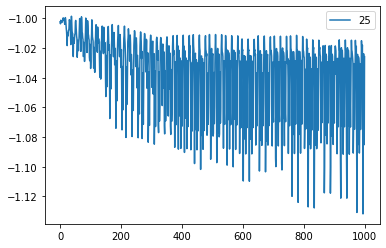

In [113]:
#View original loss and target loss
update_freqs = [int(300/batch)]
result = []
for up in update_freqs:
    w = torch.rand([channels,300,1], requires_grad=True, dtype=torch.float, device=device)
    #optimizer = optim.SGD([w], lr=100, momentum=0.9, nesterov=True)
    optimizer = optim.Adam([w], lr=0.01)
    result.append(train_run(up, 10, 20000, Tn))
    plt.plot([x.item() for x in result[-1][0]], label=str(up))
plt.legend()
plt.show()

(512, 912, 3)


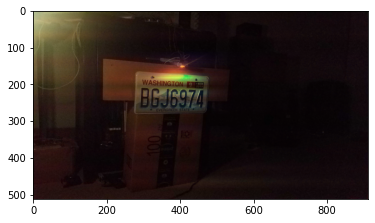

In [114]:
# example of image with pattern
image = result[0][4][5].cpu().detach().numpy().transpose(1, 2, 0)
print(image.shape)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [115]:
# LP confidence for last batch
for i in range(batch):
    print(i)
    print(result[0][1][i][:,:,0][result[0][1][i][:,:,0]>0.5].cpu().detach().numpy())

0
[0.89360976 0.9216573  0.8964039  0.94927    0.99741685 0.99973804
 0.9998271  0.9995447  0.99837697 0.9540665  0.99344134 0.99978083
 0.9999726  0.99998033 0.99995065 0.9997991  0.99889106 0.8233444
 0.99661285 0.99926597 0.9996049  0.9997111  0.99653816 0.94738925]
1
[0.8824501  0.9143833  0.8752207  0.9512344  0.99753666 0.99975175
 0.99983    0.9995448  0.9983512  0.9152147  0.99359083 0.99980396
 0.9999752  0.99998224 0.9999546  0.9998173  0.99889696 0.81829363
 0.9969342  0.99930966 0.999617   0.9997273  0.99621636 0.9448666 ]
2
[0.8747426  0.912084   0.86922014 0.94753104 0.9975291  0.9997582
 0.9998349  0.9995516  0.99832946 0.91178834 0.9926409  0.9997787
 0.99997497 0.99998283 0.99995553 0.9998266  0.99892384 0.82247657
 0.996357   0.9992398  0.9995876  0.9997168  0.995533   0.92576987]
3
[0.86435777 0.9078473  0.86029667 0.9333554  0.9972378  0.999741
 0.9998276  0.9995509  0.9982529  0.8945397  0.99152243 0.9997217
 0.99997246 0.9999825  0.9999542  0.99982685 0.9989171  0

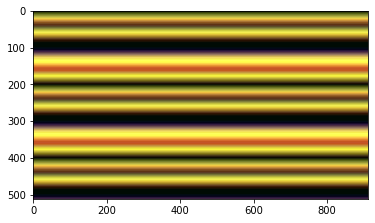

In [116]:
# pattern image
image = result[0][2][0].repeat(1,1,912).cpu().detach().numpy().transpose(1, 2, 0)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

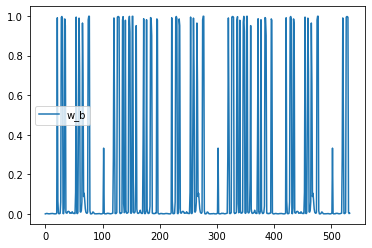

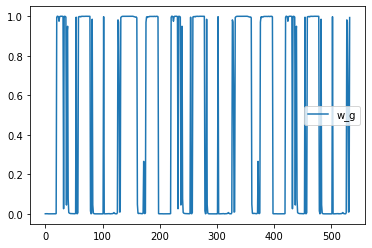

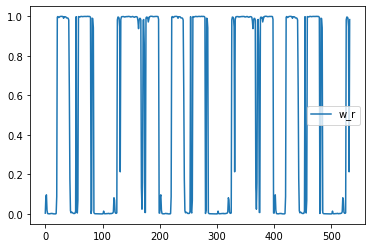

In [117]:
# signal plot
plt.plot(torch.flatten(result[0][3][0][0]).detach().cpu(), label="w_b")
plt.legend()
plt.show()
plt.plot(torch.flatten(result[0][3][0][1]).detach().cpu(), label="w_g")
plt.legend()
plt.show()
plt.plot(torch.flatten(result[0][3][0][2]).detach().cpu(), label="w_r")
plt.legend()
plt.show()

In [24]:
def applyMask(new_w, batch_limits, mask, c_limits, sig_height, conv_size, precision_depth=2):
    
    lay = torch.nn.Conv1d(1,1,conv_size)

    #Manually setting the weights and bias so the  shutter acts as a box filter
    lay.weight.data = torch.full([1,1,conv_size,1], 1/conv_size, requires_grad=True, dtype=torch.float, device=device)
    lay.bias.data = torch.zeros(1, requires_grad=True, dtype=torch.float, device=device)
    
    sz = new_w.shape[1]
    batch = batch_limits[1]-batch_limits[0]
    #stack the signal to fit the input size
    new_w = stack(new_w,sig_height)             
    
    # EOT sampling for ambient light and shift
    c = torch.rand([batch,1,1,1], device=device) * (c_limits[1] - c_limits[0]) + c_limits[0]
    shift = torch.tensor(range(batch_limits[0],batch_limits[1]), dtype=torch.int)
    #shift = torch.from_numpy(np.array(range(0,batch,1)))
    
    #Shift the signal
    new_w = shift_operation(new_w.unsqueeze(0).repeat(batch,1,1,1).view(-1, sig_height, 1), shift).view(batch,3,sig_height,1)
    
    #Fit w into the range [0,1]. new_w is the same as ft
    #new_w = .5 * (torch.tanh(ootn) + 1)
    
    #precision limit
    new_w = diff_round(new_w, precision_depth)
    
    #Convolution of ft and the shutter
    #gy = lay(new_w.unsqueeze(0).view([3,1,228,batch])).view([batch,3,224,1])
    gy = lay(new_w.transpose(0,3).transpose(0,1)).transpose(0,1).transpose(0,3)

    #Mask the signal to only affect the object
    if mask:
        gy_mask = torch.mul(gy,torch.transpose(mask,1,0))
    else:
        gy_mask = gy

    return (c + (1-c)*gy_mask), c

In [26]:
def get_ocr(count):
    ocr_threshold = .4

    ocr_weights = bytes('data/ocr/ocr-net.weights', encoding="utf-8")
    ocr_netcfg  = bytes('data/ocr/ocr-net.cfg', encoding="utf-8")
    ocr_dataset = bytes('data/ocr/ocr-net.data', encoding="utf-8")

    ocr_net  = dn.load_net(ocr_netcfg, ocr_weights, 0)
    ocr_meta = dn.load_meta(ocr_dataset)

    imgs_path = bytes('./temp/lp'+str(count)+'.jpg', encoding="utf-8")

    bname = basename(splitext(imgs_path)[0])

    R = detect(ocr_net, ocr_meta, imgs_path ,thresh=ocr_threshold, nms=None)

    if len(R):

        L = dknet_label_conversion(R,240,80)
        L = nms(L,.45)

        L.sort(key=lambda x: x.tl()[0])
        lp_str = ''.join([chr(l.cl()) for l in L])

        return lp_str
    return ""

/afs/cs.wisc.edu/u/h/o/hooda/Documents/renv/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice.


nan


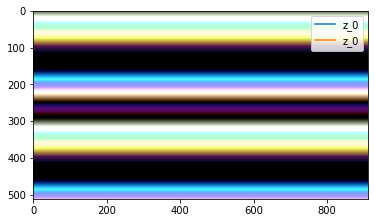

[(0, 2268, 0, 4032)]
Mean max accuracy =  nan


/afs/cs.wisc.edu/u/h/o/hooda/Documents/renv/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice.


ZeroDivisionError: division by zero

In [34]:
#ww = result[0][3]#
ww = torch.load('Plate_examples/300_full_rand_max1_affine0_lr0.1_amb_10000.pt', map_location=torch.device('cpu'))
ww = ww.to(device)
ww = ww[0]
sig_height = model_img_size + conv_size - 1
max_accuracies = [[] for i in range(len(zoom_metrics))]
recovered_characters = [[] for i in range(len(zoom_metrics))]
for z in range(len(zoom_metrics)):
    for i in range(0,1):
        torch.cuda.empty_cache()
        gy, c = applyMask(ww, [i,i+1], None, [0,0], sig_height, conv_size, 0)
        #ims = tensor_to_pil((Tn[0] + gy*(Tn[1]-Tn[0]))[0].cpu().detach())
        #b, g, r = ims.split()
        #Image.merge("RGB", (r, g, b)).save("temp/digital_evaluation/"+"dig_"+str(z)+"_"+str(i)+".jpg")
        #continue
        Yr = wpod_net(Tn[0] + gy*(Tn[1]-Tn[0])).permute(0,2,3,1)
        #display(tensor_to_pil((Tn[0] + gy*(Tn[1]-Tn[0]))[0].cpu()))
        #print(Yr[0][:,:,0][Yr[0][:,:,0]>0.5].cpu().detach().numpy())
        max_accuracies[z] += list(torch.max(torch.max(Yr[:,:,:,0],dim=1)[0],dim=1)[0].cpu().detach().numpy())
        for i in range(Yr.size()[0]):
            L,TLps = reconstruct(Ivehicle,getResizedImage(im2single(Ivehicle),2**4),Yr[i].cpu().detach().numpy(),(240,80),0.5)
            if len(TLps):
                Ilp = TLps[0]
                Ilp = cv2.cvtColor(Ilp, cv2.COLOR_BGR2GRAY)
                Ilp = cv2.cvtColor(Ilp, cv2.COLOR_GRAY2BGR)
                cv2.imwrite('./temp/lp'+str(i)+'.jpg',255*Ilp)
                ocr_text = get_ocr(i)
                recovered_characters[z].append(len([t for t in "BGJ6974" if t in ocr_text]))
            else: recovered_characters[z].append(0)
        del gy
        del Yr
        torch.cuda.empty_cache()
#image = gy[0].repeat(1,1,912).cpu().detach().numpy().transpose(1, 2, 0)
#print(max_accuracies)
for z in range(len(zoom_metrics)):
    plt.plot(max_accuracies[z],label="z_"+str(z))
#plt.legend()
#plt.show()
for z in range(len(zoom_metrics)):
    print(np.array(recovered_characters[z]).mean())
    plt.plot([x/7 for x in recovered_characters[z]],label="z_"+str(z))
plt.legend()
plt.show()
print(zoom_metrics)
print('Mean max accuracy = ',np.array(max_accuracies[0]).mean())
print('LP detection success rate = ',len([x for x in max_accuracies[0] if x>0.5])/len(max_accuracies[0]))
print('OCR success rate = ',len([x for x in recovered_characters[0] if x==7])/len(recovered_characters[0]))
'''
image = (gy[0]*Tn)[0].cpu().detach().numpy().transpose(1, 2, 0)
print(image.shape)
b = image.copy()
b[:,:,1] = 0
b[:,:,2] = 0
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
'''

In [125]:
#torch.save(result[0][3],'Plate_examples/200_full_rand_max0_affine1_lr0.1_amb_10000.pt')